# Jupyter-Based UI for Assignment2

This notebook replaces the original `action_client.py` (Node A) from the `assignment_2_2024` ROS package.

It provides:
- A graphical interface to assign and cancel goals for the robot
- Live feedback on robot position and obstacle proximity
- Real-time plots of the robot’s trajectory and goal outcomes

This interface connects directly to:
- `/reaching_goal` action server (handled by `bug_as.py`)
- `/odom` and `/scan` topics (for position and obstacle detection)
- `/last_target` topic (publishes the last sent goal)

The notebook requires that ROS environment and Gazebo simulation are launched before running.


# Section 1: Graphical Interface

## Part 1: Import Required Libraries

We import all the necessary Python and ROS libraries to:
- Communicate with the ROS action server and topics
- Build the interactive control panel using Jupyter widgets
- Visualize the robot's trajectory and goal statistics using matplotlib


In [2]:
import rospy
import actionlib
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
#from geometry_msgs.msg import Point
from std_msgs.msg import String
from assignment_2_2024.msg import PlanningAction, PlanningGoal


import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Part 2: Node Setup and Global State

We initialize the notebook as a ROS node (`jupyter_action_client`) and define global variables:

- `client`: the action client that communicates with the `/reaching_goal` server
- `odom_sub` and `scan_sub`: subscribers for odometry and laser scan data
- `last_target_pub`: publishes the last target coordinates to `/last_target`
- `current_position`: stores the robot’s real-time x/y position
- `reached_goals` and `failed_goals`: lists to track the outcome of each goal

These variables allow us to monitor and control the robot throughout the session.


In [3]:
rospy.init_node('jupyter_action_client', anonymous=True)

client = None
odom_sub = None
scan_sub = None
last_target_pub = None

current_position = {'x': 0.0, 'y': 0.0}
regions_ = {}
reached_goals = []
failed_goals = []

## Part 3: Interface Widgets for Goal Control

This Part creates the graphical controls for interacting with the robot:

- Sliders: to specify the x and y coordinates of the goal
- Buttons: to send or cancel goals


In [ ]:
x_slider = widgets.FloatSlider(value=0.0, min=-9.0, max=9.0, step=0.5, description='X:')
y_slider = widgets.FloatSlider(value=0.0, min=-9.0, max=9.0, step=0.5, description='Y:')

send_button = widgets.Button(description='Send Goal', button_style='success')
cancel_button = widgets.Button(description='Cancel Goal', button_style='danger')

position_label = widgets.Label(value="Robot Position: (0.00, 0.00)")
obstacle_label = widgets.Label(value="Distance to nearest obstacle: N/A")

ui = widgets.VBox([
    x_slider,
    y_slider,
    widgets.HBox([send_button, cancel_button]),
    position_label,
    obstacle_label
])

display(ui)

## Part 4: Subscribers for Robot State and Laser Scans

We subscribe to two key topics:
- `/odom`: for real-time robot position, updated in `current_position`
- `/scan`: for distance to obstacles, segmented into five angular regions

The callback functions update the UI labels to reflect the most current robot position and nearest obstacle direction and distance.

Utility functions `argmin` and `get_min_laser` help identify the closest region from the scan.


In [6]:
def odom_callback(msg):
    global current_position
    current_position['x'] = msg.pose.pose.position.x
    current_position['y'] = msg.pose.pose.position.y
    position_label.value = f"Robot Position: ({current_position['x']:.2f}, {current_position['y']:.2f})"

def scan_callback(msg):
    global regions_
    regions_ = {
        'right':  min(min(msg.ranges[0:143]), 10),
        'fright': min(min(msg.ranges[144:287]), 10),
        'front':  min(min(msg.ranges[288:431]), 10),
        'fleft':  min(min(msg.ranges[432:575]), 10),
        'left':   min(min(msg.ranges[576:719]), 10),
    }
    min_val, direction = get_min_laser(regions_)
    obstacle_label.value = f"Distance to nearest obstacle: {min_val:.2f} (Direction: {direction})"

def argmin(lst):
    i, val = min(enumerate(lst), key=lambda x: x[1])
    return i, val

def get_min_laser(regions):
    idx, val = argmin(list(regions.values()))
    return val, list(regions.keys())[idx]

## Part 5: Action Client for Sending and Canceling Goals

We set up the ROS action client for the `/reaching_goal` action server.

- `send_goal_callback`: sends the selected goal coordinates using `PlanningGoal`, and also publishes the goal to `/last_target`
- `cancel_goal_callback`: cancels the current goal
- `feedback_cb`: logs feedback when a goal is reached or cancelled, storing the result for visual feedback

This Part replicates the logic in `action_client.py` using the interactive widgets in place of console input.

Now we can test the widgets we put previously.

In [7]:
def feedback_cb(feedback):
    if feedback.stat == "Target reached!":
        reached_goals.append((current_position['x'], current_position['y']))
        print("Target reached!")
    elif feedback.stat == "Target cancelled!":
        failed_goals.append((current_position['x'], current_position['y']))
        print("Goal cancelled.")

def send_goal_callback(b):
    goal = PlanningGoal()
    goal.target_pose.pose.position.x = x_slider.value
    goal.target_pose.pose.position.y = y_slider.value
    client.send_goal(goal, feedback_cb=feedback_cb)

    last_target_pub.publish(f"{x_slider.value}, {y_slider.value}")
    print(f"Sent goal to ({x_slider.value}, {y_slider.value})")

def cancel_goal_callback(b):
    client.cancel_goal()
    print("Cancelled current goal.")

send_button.on_click(send_goal_callback)
cancel_button.on_click(cancel_goal_callback)

client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
print("Waiting for action server...")
client.wait_for_server()
print("Connected to action server!")

odom_sub = rospy.Subscriber('/odom', Odometry, odom_callback)
scan_sub = rospy.Subscriber('/scan', LaserScan, scan_callback)
last_target_pub = rospy.Publisher('/last_target', String, queue_size=10)

Waiting for action server...
Connected to action server!


# Section 2: Trajectory Plotting

## Part 1: Set Up Live Visualization Plots

We prepare two subplots using matplotlib:
- Left plot: robot trail (blue), current position (red), reached goals (green), and failed goals (red X)
- Right plot: pie chart showing the ratio of reached vs failed goals

This setup enables real-time monitoring of the robot's movement and task performance.


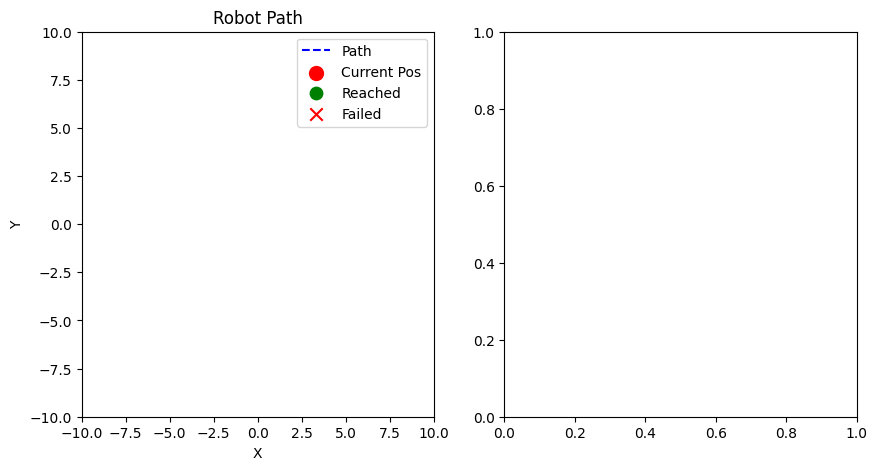

In [13]:
x_data = []
y_data = []

fig, (ax_trail, ax_summary) = plt.subplots(1, 2, figsize=(10, 5))
trail_line, = ax_trail.plot([], [], 'b--', label='Path')
current_dot = ax_trail.scatter([], [], c='red', s=100, label='Current Pos')
reached_scatter = ax_trail.scatter([], [], c='green', s=80, label='Reached')
failed_scatter = ax_trail.scatter([], [], c='red', marker='x', s=80, label='Failed')

ax_trail.set_xlim(-10, 10)
ax_trail.set_ylim(-10, 10)
ax_trail.set_title("Robot Path")
ax_trail.set_xlabel("X")
ax_trail.set_ylabel("Y")
ax_trail.legend()

## Part 2: Live Animation of Robot Position and Goal Outcomes

Using `FuncAnimation`, we update the plots at regular intervals:

- The robot’s path is updated as it moves
- Reached and failed goal positions are updated
- The goal outcome pie chart is refreshed

This section provides visual insight into how the robot is performing over time.


In [14]:
def update_goal_plot():
    ax_summary.clear()
    r, f = len(reached_goals), len(failed_goals)
    ax_summary.pie([r, f], labels=["Reached", "Failed"], colors=["green", "red"], autopct="%1.0f%%")
    ax_summary.set_title("Goal Outcome")

def update(frame):
    x = current_position['x']
    y = current_position['y']
    x_data.append(x)
    y_data.append(y)

    trail_line.set_data(x_data[-400:], y_data[-400:])
    current_dot.set_offsets([[x, y]])

    if reached_goals:
        reached_scatter.set_offsets(reached_goals)
    if failed_goals:
        failed_scatter.set_offsets(failed_goals)

    update_goal_plot()
    return trail_line, current_dot, reached_scatter, failed_scatter

ani = FuncAnimation(fig, update, interval=200)

<ipython-input-14-07bc1de442b3>:24: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=200)


# Section 3: Full UI With Visualization

We combine the widgets and plots into a complete interactive dashboard:

- Users can set or cancel goals using sliders and buttons
- The robot’s position and obstacle info update live
- Plots provide continuous visual feedback on the robot’s trajectory and performance

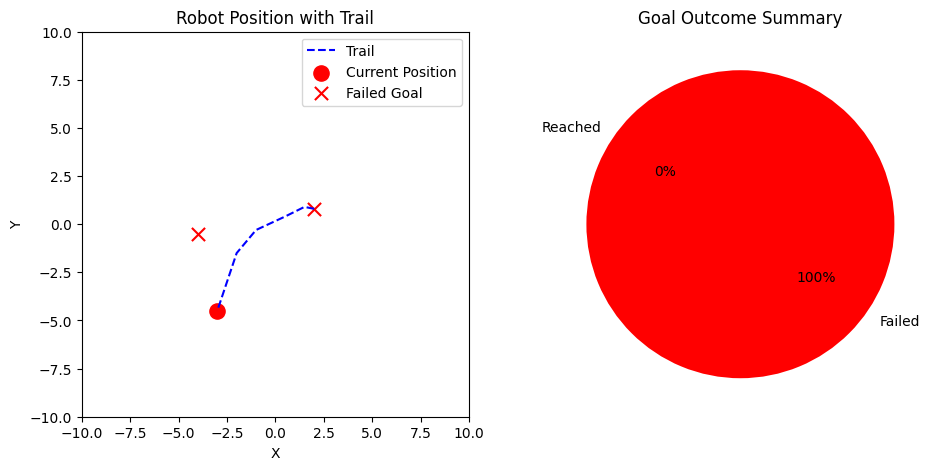

In [40]:
%matplotlib inline

display(ui)
display(fig)